**Problem**: 

Approximating the non-linear data space that makes up a PyPSA simulation. Specifically, approximating a modified IEEE 13 bus topology with a uniform (grid) input. The approximation is time sensitive.

**Objective**:

This notebook will only look at [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) (RF) models. Per [1], the approximation should have a root mean sqaure error < 0.002 to ensure the approximation is not the largest source of error in the simulation. A standard linear regression will also be calculated for baseline comparison. Since the approximation is time sensitive, a search for the ball park number of samples required for reasonable scores is performed. Once the number of samples to produce reasonable results is found, a grid search can be ran to determine optimal training parameters.

**Hypothesis**: 

Previously, a linear regression model outperformed a non-linear model (artificial neural network) when tested on simple, small radial networks [2]. Since the modified IEEE 13 bus network contains two transformers whos behaviour can become non-linear if their power limit is exceeded (which is allowed in power flow [3]), I suspect there are two possible scenarios:

1. Transformer limit not exceeded: Linear regression outperforms RF model
2. Transformer limit exceeded: RF outperforms linear regressor because a RF model can capture non-linearity 

As for the number of samples required, historically 1e5-1e6 samples produces K-fold cross validation scores with low variance if the feature-label correlation is reasonable.

**Experimental Procedure**:

1. Determine the number of samples required to return reasonable scores with SVR K-fold cross validation. Reasonable scores is defined as:
  * R2 > 0.8
  * RMSE < 0.002
  * K-fold R2 variance one degree of magnitude less than R2
2. Using approximately that number of samples, run grid search to determine optimal parameters/hyperparameters

**Results**:

* Remove vmag-650 (label with low correlation)

| n_samples         |      10000 |
|:------------------|-----------:|
| rf_fit_time       | 9.21089    |
| rf_score_time     | 0.401678   |
| rf_test_r2        | 0.695272   |
| rf_test_rmse      | 0.0124462  |
| rf_test_mae       | 0.00749554 |
| rf_test_maxae     | 0.115713   |
| linear_fit_time   | 0.00617342 |
| linear_score_time | 0.0112908  |
| linear_test_r2    | 0.473663   |
| linear_test_rmse  | 0.0165817  |
| linear_test_mae   | 0.0116169  |
| linear_test_maxae | 0.107746   |

compared to ieee-13_approximating-with-RF_uniformsamples results

| n_samples         |        100 |       1000 |      10000 |       100000 |
|:------------------|-----------:|-----------:|-----------:|-------------:|
| rf_fit_time       | 0.122987   | 0.748524   | 9.27673    | 123.682      |
| rf_score_time     | 0.0278018  | 0.0557152  | 0.40257    |   5.01405    |
| rf_test_r2        | 0.592921   | 0.779157   | 0.891668   |   0.961907   |
| rf_test_rmse      | 0.0066322  | 0.0047523  | 0.00338417 |   0.00202573 |
| rf_test_mae       | 0.00541554 | 0.00372985 | 0.00262908 |   0.0013697  |
| rf_test_maxae     | 0.016915   | 0.0184438  | 0.0160934  |   0.0151965  |
| linear_fit_time   | 0.00256686 | 0.00140066 | 0.00833402 |   0.139149   |
| linear_score_time | 0.00134931 | 0.00221643 | 0.0132148  |   0.196948   |
| linear_test_r2    | 0.980572   | 0.980573   | 0.981777   |   0.981277   |
| linear_test_rmse  | 0.00146334 | 0.00144984 | 0.00143737 |   0.00145341 |
| linear_test_mae   | 0.00119668 | 0.0011302  | 0.00113293 |   0.00114577 |
| linear_test_maxae | 0.00455751 | 0.00585088 | 0.00738675 |   0.00775007 |


**Discussion**:

One approach to reduce the cost of simulation-based research is to copy the underlying model and evaluate the approximation [1][4].

It takes roughly 7 hours to create 1e5 samples (by running PyPSA sim) on Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz


**Bibliography**

[1] https://github.com/mbardwell/masters

[2] Enhancing Power Flow Simulations Using Function Mapping. Michael Bardwell ; Petr Musilek. 2019 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE)

[3] https://groups.google.com/forum/#!searchin/pypsa/mikey%7Csort:date/pypsa/FqfC_UR85k0/vBc7HYP_EQAJ

[4] ieee-13_timing-pfsim-vs-evaluating-models.ipynb


Table of Contents:
* Source data
* Analyse data
* Setup models
* Determine number of samples to get reasonable scores
* Search

In [1]:
import copy
import csv
import importlib
import logging
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypsa
import seaborn as sns

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

In [5]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name + "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)


def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    import pandas as pd
    
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")


def set_uniform_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''

    Parameters
    ----------
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"] 
    '''

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
          
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                ## special cases
                if datatype == "generators-p_max_pu":
                    # add a ridiculous amount of generation so the is always enough power and sim doesn't fail
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=100, high=200, size=n_samples)
                elif datatype == "snapshots":
                    addon[column] = np.ones(n_samples)
                else:
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=0, high=0.5, size=n_samples)
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][0])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(1).append(addon_dataframe)

    for datatype in data:
        data[datatype] = increase_data(data[datatype], n_samples-1, seed) # -1 is for original sample, which stays
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))


def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    from pathlib import Path
    import shutil
    
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/"  # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_uniform_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf(x_tol=1e-9)

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")


def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import errno
    import os
    import shutil

    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Backup was not successful. Directory not copied. Error: %s' % e)



def add_mean_and_std_rows(dataframe):
    mean = dataframe.mean()
    std = dataframe.std()
    dataframe.loc["mean"] = mean
    dataframe.loc["std"] = std
    return dataframe


def maxae(y, y_pred, **kwargs):
    import numpy as np
    return max(np.abs(y-y_pred).ravel())

def rmse(y, y_pred, **kwargs):
    import operator
    return np.sqrt(np.mean(np.square(list(map(operator.sub, y, y_pred)))))

def set_data_size(features, labels, n_samples, n_training_samples):
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val, train_idx, test_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)

    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val, test_idx, train_idx

def train_models_on_given_sample_size(regression_model, features, labels, n_samples_array=[100, 1000, 10000, 100000], prompt=True):
    """
    Trains regression model on a variety of sample sizes
    
    parameters
    ----------
    features: pandas DataFrame
    labels: pandas DataFrame
    n_sample_array: array
        ex: [100, 1000, 10000, 100000]
    regression_model: sklearn regressor
        ex: RandomForestRegressor
    """
    import datetime

    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import make_scorer, r2_score
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.model_selection import cross_validate, train_test_split
    from tabulate import tabulate
    
    if prompt == True:
        savefile_descriptor_addon = input("Add on extra descriptor to saved file (ex: -testing_maxae)? ")
    else:
        if isinstance(prompt, str):
            savefile_descriptor_addon = prompt
        else:
            print("Prompt not a string. Foregoing descriptor")
            savefile_descriptor_addon = ''
    linear = LinearRegression()
    common_cross_validate_variables = {"cv": 5,
                                       "n_jobs": -1,
                                       "scoring": {"r2": make_scorer(r2_score), 
                                                   "rmse": make_scorer(rmse),
                                                   "mae": make_scorer(mae),
                                                   "maxae": make_scorer(maxae)}}
    summary = {}

    for i, n_samples in enumerate(n_samples_array):
        current_iteration = i

        # do not split data into train/val; cross_validate will automatically do that
        samples_to_use = np.random.randint(0, features.shape[0], n_samples)
        X = features.iloc[samples_to_use].values
        y = labels.iloc[samples_to_use].values
        
        print("\n\nRun: ", current_iteration)
        print("n_samples for k fold cross validation: ", n_samples)
        print("n_features: ", X.shape[1])
        print("n_labels: ", y.shape[1])

        ## regression model to evaluate
        print("\n\n{} REGRESSION\n\n".format(regression_model_name.upper()))
        time_start = time.time()
        regression_model_results = pd.DataFrame(cross_validate(regression_model, X, y, 
                                                               **common_cross_validate_variables))
        time_regression_model = time.time()
        print("cross validation training time {:.5}".format(time_regression_model-time_start))
        print("cross validation training scores: ")
        regression_model_results.columns = [regression_model_name+"_"+col for col in regression_model_results.columns]
        regression_model_results = add_mean_and_std_rows(regression_model_results)
        display(regression_model_results)

        print("non-cross validation model scores for reference:")
        n_training_samples = int(n_samples*80/100)
        X_train, y_train, X_val, y_val, _, _ = set_data_size(features, labels, n_samples, n_training_samples)
        regression_model.fit(X_train, y_train)
        print("n_training_samples: ", n_training_samples)
        print("n_validation_samples: ", n_samples-n_training_samples)
        print("training score: ", r2_score(y_train, regression_model.predict(X_train)))
        print("validation score: ", r2_score(y_val, regression_model.predict(X_val)))
        print("rmse: ", rmse(regression_model.predict(X_val), y_val))



        ## linear regression for baseline comparison
        print("\n\nLINEAR REGRESSION\n\n")
        time_start = time.time()
        linear_results = pd.DataFrame(cross_validate(linear, X, y, **common_cross_validate_variables))
        time_linear = time.time()
        print("cross validation training time {:.5}".format(time_linear-time_start))
        print("cross validation training scores: ")
        linear_results.columns = ["linear_"+col for col in linear_results.columns]
        linear_results = add_mean_and_std_rows(linear_results)
        display(linear_results)

        linear.fit(X_train, y_train)
        print("non-cross validation model scores for reference:")
        print("training score: ", r2_score(y_train, linear.predict(X_train)))
        print("validation score: ", r2_score(y_val, linear.predict(X_val)))
        print("rmse: ", rmse(linear.predict(X_val), y_val))



        ## save models
        datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
        results_to_save = regression_model_results.join(linear_results)
        results_to_save.to_csv(path_to_powerflow_data + 
                               "/results/approximating_with_{}_model_results-{}_samples-uniform_input_low_tol-{}{}.csv".format(
                                   regression_model_name,
                                   n_samples, 
                                   datetimestamp,
                                   savefile_descriptor_addon))
        
        summary[n_samples] = results_to_save.loc["mean"].values

    summary = pd.DataFrame(summary, index=results_to_save.columns)
    summary_table = tabulate(summary, tablefmt="pipe", headers="keys")
    print("\n\nSUMMARY\n\n", summary_table)
    with open(path_to_powerflow_data + "/results/approximating_with_{}_model_summary-uniform_input_low_tol-{}{}.txt".format(
                  regression_model_name,
                  datetimestamp,
                  savefile_descriptor_addon), "w") as f:
        f.write(summary_table)

# Source Data

In [6]:
## USER INPUT
sample_size = 10000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example + "/ieee-13-with-load-gen-uniform-data-low-tol-" +
                          str(sample_size) + "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [7]:
# Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
# else:
#     create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

Datatype loads-p_set stored
Datatype snapshots stored
Datatype loads-q_set stored


# Analyse Data

In [8]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1)
features_and_labels = features.join(labels)

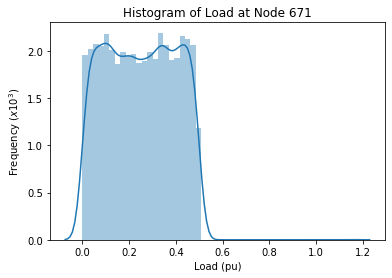

In [9]:
sns.distplot(features["load-671"], bins=50)
plt.xlabel("Load (pu)")
plt.ylabel("Frequency ($x10^3$)")
plt.title("Histogram of Load at Node 671")
# plt.savefig("uniform-samples-1e5-input-histogram.pdf")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2973a43ed0>,
      dtype=object)

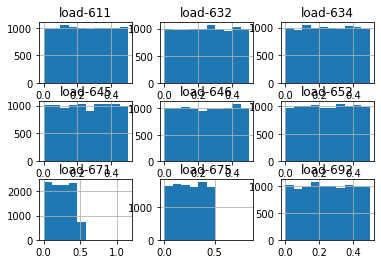

In [10]:
features.hist()

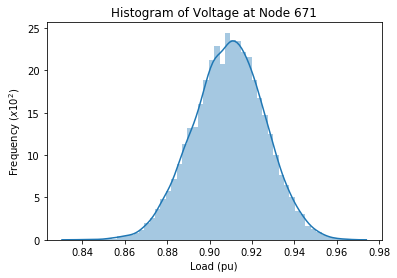

In [11]:
sns.distplot(labels["vmag-671"], bins=50)
plt.xlabel("Load (pu)")
plt.ylabel("Frequency ($x10^2$)")
plt.title("Histogram of Voltage at Node 671")
# plt.savefig("uniform-samples-1e5-voltage-histogram.pdf")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29736efb90>,
      dtype=object)

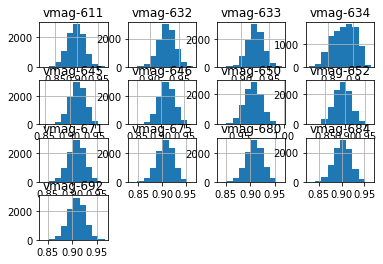

In [12]:
labels.hist()

In [13]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-650,-0.021995,-0.085876,-0.030370,-0.018466,-0.027853,-0.029175,-0.016453,-0.029775,0.000353,-0.028846
vmag-646,-0.147079,-0.188416,-0.354477,-0.460550,-0.161173,-0.162804,-0.155374,-0.163773,-0.127185,-0.213426
vmag-645,-0.154163,-0.198233,-0.374321,-0.363083,-0.169673,-0.172791,-0.162099,-0.171289,-0.136166,-0.211313
vmag-632,-0.178133,-0.225523,-0.195811,-0.180404,-0.194154,-0.195684,-0.180616,-0.191164,-0.159882,-0.189041
vmag-633,-0.171640,-0.336762,-0.189290,-0.173776,-0.188358,-0.187736,-0.170371,-0.183761,-0.150582,-0.194697
vmag-634,-0.055995,-0.185647,-0.068771,-0.065337,-0.070220,-0.063421,-0.051641,-0.045240,-0.036501,-0.071419
vmag-611,-0.129382,-0.157222,-0.150076,-0.128109,-0.362237,-0.258604,-0.246277,-0.248909,-0.435770,-0.235176
vmag-684,-0.135865,-0.166806,-0.156429,-0.135571,-0.377591,-0.271108,-0.257080,-0.260924,-0.348922,-0.234477
vmag-671,-0.148049,-0.181197,-0.168324,-0.148100,-0.292228,-0.293085,-0.278900,-0.284267,-0.262275,-0.228492
vmag-692,-0.148038,-0.181178,-0.168313,-0.148091,-0.292199,-0.293061,-0.279017,-0.284382,-0.262251,-0.228503


# Determine number of samples to get reasonable scores

In [14]:
# setup model parameters/hyperparameters

'''
dnn hyperparameters are chosen from sandbox testing. On average the model attempts to converge 
(with other parameters it sometimes gives up early).
'''
from sklearn.ensemble import RandomForestRegressor

regression_model = RandomForestRegressor(n_estimators=100, max_depth=None)
regression_model_name = "rf"

In [15]:
# went straight to what returned the best results in ieee-13_approximating-with-RF_uniformsamples
# drop labels with poor correlation by not including them in the data set
from sklearn.pipeline import Pipeline

attributes = list(labels.keys())
attributes.remove("vmag-650")
labels_reduced = labels[attributes]

estimators = [('regression', regression_model)]
preprocessed_model = Pipeline(estimators)
train_models_on_given_sample_size(preprocessed_model, features, labels_reduced, 
                                  n_samples_array=[10000], prompt="-without_vmag650")



Run:  0
n_samples for k fold cross validation:  10000
n_features:  9
n_labels:  12


RF REGRESSION


cross validation training time 29.944
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,9.120465,0.407343,0.683915,0.012663,0.007648,0.127889
1,9.253100,0.417237,0.690888,0.012488,0.007482,0.117039
2,9.225541,0.399206,0.701963,0.012305,0.007405,0.106372
3,9.121033,0.394665,0.699319,0.012351,0.007471,0.115886
4,9.334304,0.389940,0.700277,0.012425,0.007472,0.111381
mean,9.210889,0.401678,0.695272,0.012446,0.007496,0.115713
std,0.091486,0.010808,0.007655,0.000140,0.000090,0.008001


non-cross validation model scores for reference:
n_training_samples:  8000
n_validation_samples:  2000
training score:  0.9169651221679721
validation score:  0.401705813021583
rmse:  0.017651727773472976


LINEAR REGRESSION


cross validation training time 0.09616
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.007856,0.010047,0.470811,0.016705,0.011701,0.112215
1,0.006744,0.014211,0.465044,0.016652,0.011610,0.107485
2,0.006029,0.011231,0.485348,0.016502,0.011627,0.106359
3,0.005424,0.011420,0.481601,0.016420,0.011456,0.106011
4,0.004814,0.009545,0.465511,0.016630,0.011691,0.106660
mean,0.006173,0.011291,0.473663,0.016582,0.011617,0.107746
std,0.001182,0.001813,0.009333,0.000117,0.000098,0.002557


non-cross validation model scores for reference:
training score:  0.4643831987119955
validation score:  0.4656726575008579
rmse:  0.01692938751890644


SUMMARY

 |                   |      10000 |
|:------------------|-----------:|
| rf_fit_time       | 9.21089    |
| rf_score_time     | 0.401678   |
| rf_test_r2        | 0.695272   |
| rf_test_rmse      | 0.0124462  |
| rf_test_mae       | 0.00749554 |
| rf_test_maxae     | 0.115713   |
| linear_fit_time   | 0.00617342 |
| linear_score_time | 0.0112908  |
| linear_test_r2    | 0.473663   |
| linear_test_rmse  | 0.0165817  |
| linear_test_mae   | 0.0116169  |
| linear_test_maxae | 0.107746   |
